# Natural Language Processing YELP review

In this notebook we will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews.

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.


## Import libraries

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

## Data

In [3]:
df = pd.read_csv('yelp.csv')
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [6]:
df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


**Create a new column called "text length" which is the number of words in the text column.**

In [15]:
df['text length'] = df['text'].apply(len)

# EDA


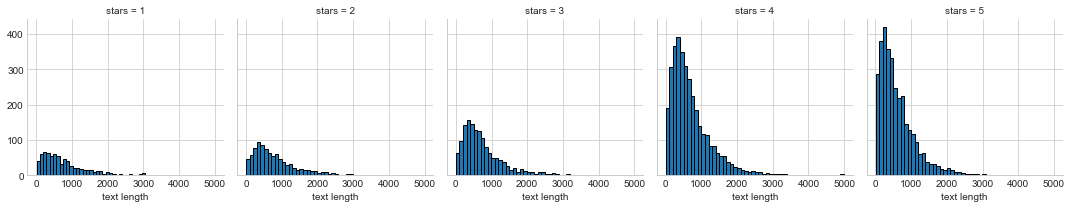

In [20]:
sns.set_style('whitegrid')
plt.rcParams["patch.force_edgecolor"] = True
g = sns.FacetGrid(df, col = 'stars')
g.map(plt.hist, 'text length', bins = 50)

We can notice that all the stars reviews have the same distribution and that in general there are more four and five stars reviews

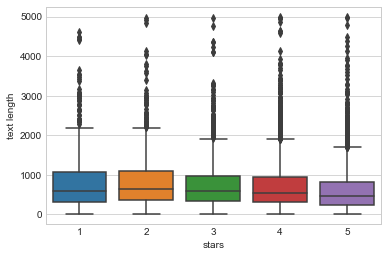

In [18]:
sns.boxplot(x = df['stars'], y = df['text length'])

From this figure we can notice that 1 and 2 stars reviews have greater length but we can also notice that there are lot of outliers

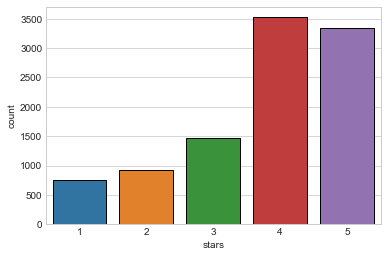

In [19]:
sns.countplot(x = df['stars'])

In [23]:
stars = df.groupby(by = 'stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


Let's check the correlation between variables

In [25]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


**Then use seaborn to create a heatmap based off that .corr() dataframe:**

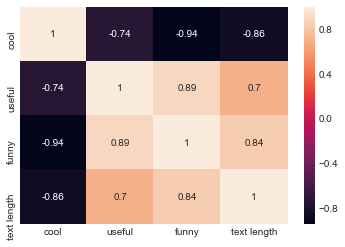

In [26]:
sns.heatmap(stars.corr(),annot = True)

## Classification 

Let's grab reviews that were either 1 star or 5 stars.

In [32]:
yelp_class = df[(df['stars'] == 1) | (df['stars'] == 5)]
yelp_class.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565


In [33]:
yelp_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4086 entries, 0 to 9999
Data columns (total 11 columns):
business_id    4086 non-null object
date           4086 non-null object
review_id      4086 non-null object
stars          4086 non-null int64
text           4086 non-null object
type           4086 non-null object
user_id        4086 non-null object
cool           4086 non-null int64
useful         4086 non-null int64
funny          4086 non-null int64
text length    4086 non-null int64
dtypes: int64(5), object(6)
memory usage: 383.1+ KB


In [34]:
X = yelp_class['text']
y = yelp_class['stars']

Let's create a CountVectorizer object.

In [38]:
cv = CountVectorizer()

In [39]:
X = cv.fit_transform(X)

## Train Test Split

Let's split our data into training and testing data.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Training a Model

We can now train our model by using Multinomial Naive Bayes

In [54]:
nb = MultinomialNB()

In [55]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predictions and Evaluations

Now we can make predictions on our test data

In [56]:
predictions = nb.predict(X_test)

** Create a confusion matrix and classification report using these predictions and y_test **

In [57]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions))

Confusion Matrix:
[[159  69]
 [ 22 976]]


In [58]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          1       0.88      0.70      0.78       228
          5       0.93      0.98      0.96       998

avg / total       0.92      0.93      0.92      1226



Now let's see what happens if we try to include TF-IDF to this process using a pipeline

# Using Text Processing

In [76]:
pipe = Pipeline([('bow', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

### Train Test Split

Redo the train test split on the yelp_class object.

In [77]:
X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

Now fit the pipeline to the training data

In [78]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...ear_tf=False, use_idf=True)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Predictions and Evaluation

Now use the pipeline to predict from the X_test and create a classification report and confusion matrix

In [79]:
predictions = pipe.predict(X_test)

In [80]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions))

Confusion Matrix:
[[  0 228]
 [  0 998]]


In [81]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00       228
          5       0.81      1.00      0.90       998

avg / total       0.66      0.81      0.73      1226



C:\Users\Marco\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Looks like Tf-Idf actually made things worse